In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.set_default_device("cuda")

In [19]:
########### MODEL CLASSES ###############


class NormalizationLayer(nn.Module):
    def __init__(self, maxnorm, input_shape):
        super(NormalizationLayer, self).__init__()
        self.maxnorm = maxnorm
        self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
    def forward(self, inputs):
        output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
        return output
    
class NoiseLayer(nn.Module):
    def __init__(self, noise_radius):
        super(NoiseLayer, self).__init__()
        self.noise_radius = noise_radius
        self.alpha = 0.5
        self.beta = 0.5
        
    def spherical_gaussian(self, num_circles):
        x = torch.randn(num_circles, 2)
        beta_distribution = torch.distributions.Beta(self.alpha, self.beta)
        u = beta_distribution.sample((num_circles,2))
        norm = torch.norm(x, dim=1, keepdim=True, p=2)
        noise = x * (u) * self.noise_radius / norm
        return noise

    def forward(self, inputs, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        noise = self.spherical_gaussian(inputs.size(0))
        return inputs + noise
    
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(True),
            nn.Linear(in_features, in_features)
        )
        
    def forward(self, x):
        return x + self.block(x)
    

class EncoderDecoder(nn.Module):
    def __init__(self, num_circles, larger_radius, smaller_radius):
        super(EncoderDecoder, self).__init__()
        
        self.main_dim = num_circles
        self.latent_dim = 2
        self.R = larger_radius
        self.r = smaller_radius
        self.mid_dim = 128
        self.mid_mid_dim = 64
        self.alpha = 0.5

        self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
        self.noise = NoiseLayer(self.r)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.main_dim, self.mid_mid_dim),
            nn.BatchNorm1d(self.mid_mid_dim),
            nn.LeakyReLU(),
            nn.Linear(self.mid_mid_dim, self.mid_dim),
            nn.BatchNorm1d(self.mid_dim),
            nn.LeakyReLU(),
            nn.Linear(self.mid_dim, self.mid_dim),
            nn.BatchNorm1d(self.mid_dim),
            nn.LeakyReLU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.BatchNorm1d(self.main_dim),
            nn.LeakyReLU(),
            nn.Linear(self.main_dim, self.latent_dim),
            nn.Tanh()
        )       
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.main_dim),
            nn.BatchNorm1d(self.main_dim),
            nn.LeakyReLU(),
            nn.Linear(self.main_dim, self.mid_mid_dim),
            nn.BatchNorm1d(self.mid_mid_dim),
            nn.LeakyReLU(),
            ResidualBlock(self.mid_mid_dim),
            nn.BatchNorm1d(self.mid_mid_dim),
            ResidualBlock(self.mid_mid_dim),
            nn.BatchNorm1d(self.mid_mid_dim),
            ResidualBlock(self.mid_mid_dim),
            # nn.Linear(self.mid_mid_dim, self.mid_mid_dim),
            # nn.LeakyReLU(),
            # nn.Linear(self.mid_mid_dim, self.mid_mid_dim),
            # nn.LeakyReLU(),
            # nn.Linear(self.mid_mid_dim, self.mid_mid_dim),
            # nn.LeakyReLU(),
            # nn.Linear(self.mid_mid_dim, self.mid_mid_dim),
            # nn.LeakyReLU(),
            # nn.Linear(self.mid_mid_dim, self.mid_dim),
            # nn.LeakyReLU(),
            # nn.Linear(self.mid_dim, self.mid_mid_dim),
            # nn.LeakyReLU(),
            nn.Linear(self.mid_mid_dim, self.main_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, alpha, beta):
        encoded = self.encoder(x)
        normal_encoded = self.normalize(encoded)
        noisy_encoded_1 = self.noise(normal_encoded, alpha, beta)
        # noisy_encoded_2 = self.noise(normal_encoded, alpha, beta)
        # noisy_encoded_3 = self.noise(normal_encoded, alpha, beta)
        # noisy_encoded = torch.cat((noisy_encoded_1, noisy_encoded_2, noisy_encoded_3), dim=0)4
        noisy_encoded = noisy_encoded_1
        decoded = self.decoder(noisy_encoded)
        return decoded

    def regions(self, x, alpha, beta, colors):
        with torch.no_grad():
            encoded = self.encoder(x)
            normal_encoded = self.normalize(encoded)
            noisy_encoded_1 = self.noise(normal_encoded, alpha, beta)
            # noisy_encoded_2 = self.noise(normal_encoded, alpha, beta)
            # noisy_encoded_3 = self.noise(normal_encoded, alpha, beta)
            noisy_encoded = noisy_encoded_1
            #noisy_encoded = torch.cat((noisy_encoded_1, noisy_encoded_2, noisy_encoded_3), dim=0)
            decoded = self.decoder(noisy_encoded).cpu()
            noisy_encoded = noisy_encoded.cpu()
            # Generate a list of unique colors for each label

            # Plotting the data
            for i in range(noisy_encoded.shape[0]):
                label_index = int(np.argmax(decoded[i]))
                plt.scatter(noisy_encoded[i, 0], noisy_encoded[i, 1], color=colors(label_index), label=f'Class {label_index}')
                plt.annotate("guess"+str(label_index), (noisy_encoded[i, 0], noisy_encoded[i, 1]), fontsize=8, ha='center', va='bottom')
            
            # Adding a legend (only one entry per class)
            #handles, labels = plt.gca().get_legend_handles_labels()
            #by_label = dict(zip(labels, handles))
            #plt.legend(by_label.values(), by_label.keys())
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('2D Coordinates with Different Colors')
            plt.show()
        return 0

    def centres(self, x):
        return self.normalize(self.encoder(x)).cpu().detach().numpy()

In [20]:
def one_hot(a, num_classes):
    return torch.tensor(np.eye(num_classes)[a], dtype=torch.float32)

In [21]:
def plot_circles_2(centres, large_radius, small_radius, colors, save = False, savename=None):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.axis('off')
    ax.add_patch(plt.Circle((0,0), radius = large_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for rad, centre in enumerate(centres):
        (x,y) = centre
        ax.add_patch(plt.Circle(centre, radius = small_radius, fill = False, linewidth = 1.0, color = colors(rad)))
        ax.annotate(str(rad), (x, y), (x, y), fontsize=12, ha='center', va='center')
    if save:
        plt.savefig(savename)


In [22]:
def plot_circles(centres, large_radius, small_radius, save = False, savename=None):
    fig, ax = plt.subplots(figsize = (2, 2))
    ax.axis('off')
    ax.scatter(0,0, color = 'red')
    ax.add_patch(plt.Circle((0,0), radius = large_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for rad, centre in enumerate(centres):
        (x,y) = centre
        #ax.annotate(str(rad+1), (x,y), (x,y), fontsize = 16)
        ax.add_patch(plt.Circle(centre, radius = small_radius, fill = False, linewidth = 1.0, color = 'blue'))
    if save:
        plt.savefig(savename)
    plt.show()

def packing_density(centres, r, R = 1, NumSamples = 100000):
    '''
    centres: centres of the spheres [N,2], N: Number of spheres
    r: radius of each circle
    R: radius of enclosing circle
    NumSamples: number of points to be sampled towards density calculation
    '''
    x = np.random.normal(size=[NumSamples, 2])
    u = np.random.uniform(size=[NumSamples, 1])
    norm = np.linalg.norm(x, axis = 1, keepdims=True)

    #these points are distributed uniformly inside the circle
    coordinates = x*np.power(u, 1/2)/norm*R
    
    centres_reshaped = np.reshape(centres, [1, centres.shape[0], centres.shape[1]])
    coordinates_reshaped = np.reshape(coordinates, [coordinates.shape[0], 1, coordinates.shape[1]])
    distances_from_centres = np.linalg.norm(coordinates_reshaped - centres_reshaped, axis = 2)
    min_distances = np.min(distances_from_centres, axis = 1)
        
    return np.sum(min_distances < r)/NumSamples

  0%|          | 0/10000 [00:00<?, ?it/s]

Epcoh 0
Packing Density : 0.76829


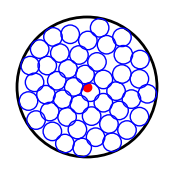

  0%|          | 1/10000 [00:03<9:23:04,  3.38s/it]

##########################


  1%|          | 100/10000 [04:47<7:40:46,  2.79s/it]

Epcoh 100
Packing Density : 0.7726


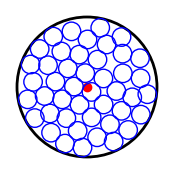

  1%|          | 101/10000 [04:50<7:55:12,  2.88s/it]

##########################


  2%|▏         | 200/10000 [09:29<7:24:56,  2.72s/it]

Epcoh 200
Packing Density : 0.77302


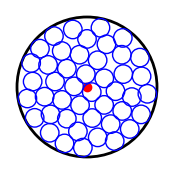

  2%|▏         | 201/10000 [09:33<7:41:49,  2.83s/it]

##########################


  3%|▎         | 300/10000 [14:10<7:56:02,  2.94s/it]

Epcoh 300
Packing Density : 0.77357


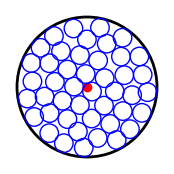

  3%|▎         | 301/10000 [14:14<8:15:34,  3.07s/it]

##########################


  4%|▍         | 400/10000 [19:06<7:46:59,  2.92s/it]

Epcoh 400
Packing Density : 0.77574


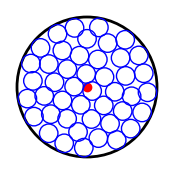

  4%|▍         | 401/10000 [19:10<8:47:17,  3.30s/it]

##########################


  5%|▌         | 500/10000 [23:49<7:21:40,  2.79s/it]

Epcoh 500
Packing Density : 0.77415


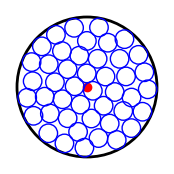

  5%|▌         | 501/10000 [23:52<7:36:43,  2.88s/it]

##########################


  6%|▌         | 600/10000 [28:32<7:06:28,  2.72s/it]

Epcoh 600
Packing Density : 0.77464


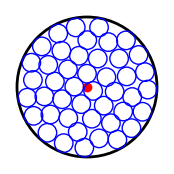

  6%|▌         | 601/10000 [28:35<7:32:48,  2.89s/it]

##########################


  7%|▋         | 700/10000 [33:06<7:05:33,  2.75s/it]

Epcoh 700
Packing Density : 0.77511


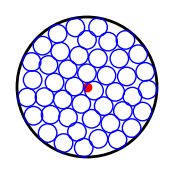

  7%|▋         | 701/10000 [33:09<7:20:26,  2.84s/it]

##########################


  8%|▊         | 800/10000 [37:40<7:00:01,  2.74s/it]

Epcoh 800
Packing Density : 0.77723


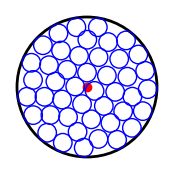

  8%|▊         | 801/10000 [37:43<7:09:42,  2.80s/it]

##########################


  9%|▉         | 900/10000 [42:17<6:58:27,  2.76s/it]

Epcoh 900
Packing Density : 0.77746


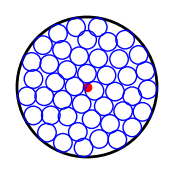

  9%|▉         | 901/10000 [42:19<7:07:28,  2.82s/it]

##########################


 10%|█         | 1000/10000 [46:52<6:50:31,  2.74s/it]

Epcoh 1000
Packing Density : 0.77574


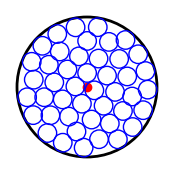

 10%|█         | 1001/10000 [46:55<7:10:18,  2.87s/it]

##########################


 11%|█         | 1100/10000 [51:28<6:54:32,  2.79s/it]

Epcoh 1100
Packing Density : 0.77784


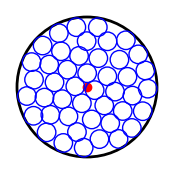

 11%|█         | 1101/10000 [51:31<7:01:46,  2.84s/it]

##########################


 12%|█▏        | 1200/10000 [56:15<6:54:54,  2.83s/it]

Epcoh 1200
Packing Density : 0.77748


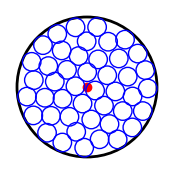

 12%|█▏        | 1201/10000 [56:19<7:28:29,  3.06s/it]

##########################


 13%|█▎        | 1300/10000 [1:01:13<7:05:01,  2.93s/it]

Epcoh 1300
Packing Density : 0.77675


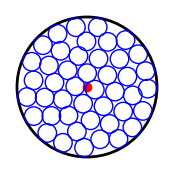

 13%|█▎        | 1301/10000 [1:01:16<7:13:53,  2.99s/it]

##########################


 14%|█▍        | 1400/10000 [1:06:17<7:05:58,  2.97s/it]

Epcoh 1400
Packing Density : 0.77616


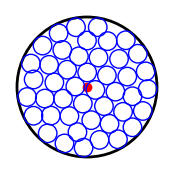

 14%|█▍        | 1401/10000 [1:06:20<7:19:32,  3.07s/it]

##########################


 15%|█▌        | 1500/10000 [1:11:42<7:45:44,  3.29s/it]

Epcoh 1500
Packing Density : 0.77903


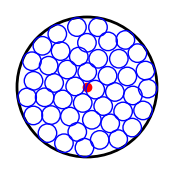

 15%|█▌        | 1501/10000 [1:11:45<7:55:53,  3.36s/it]

##########################


 16%|█▌        | 1600/10000 [1:17:15<7:53:57,  3.39s/it]

Epcoh 1600
Packing Density : 0.77664


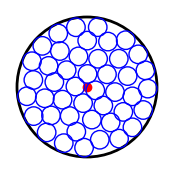

 16%|█▌        | 1601/10000 [1:17:18<7:56:03,  3.40s/it]

##########################


 17%|█▋        | 1700/10000 [1:22:38<6:26:21,  2.79s/it]

Epcoh 1700
Packing Density : 0.77634


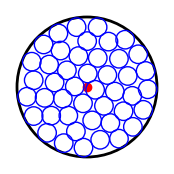

 17%|█▋        | 1701/10000 [1:22:41<6:40:40,  2.90s/it]

##########################


 18%|█▊        | 1800/10000 [1:27:28<6:37:08,  2.91s/it]

Epcoh 1800
Packing Density : 0.77769


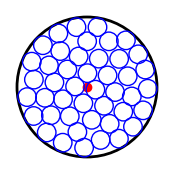

 18%|█▊        | 1801/10000 [1:27:31<6:50:15,  3.00s/it]

##########################


 19%|█▉        | 1900/10000 [1:32:22<6:39:02,  2.96s/it]

Epcoh 1900
Packing Density : 0.77705


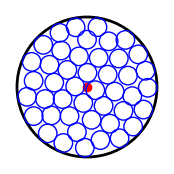

 19%|█▉        | 1901/10000 [1:32:26<7:04:22,  3.14s/it]

##########################


 20%|██        | 2000/10000 [1:37:19<6:27:50,  2.91s/it]

Epcoh 2000
Packing Density : 0.77692


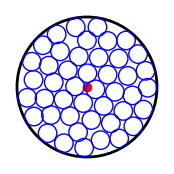

 20%|██        | 2001/10000 [1:37:22<6:41:41,  3.01s/it]

##########################


 21%|██        | 2100/10000 [1:42:16<6:28:45,  2.95s/it]

Epcoh 2100
Packing Density : 0.77929


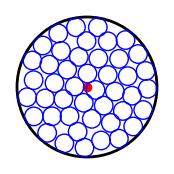

 21%|██        | 2101/10000 [1:42:19<6:53:54,  3.14s/it]

##########################


 22%|██▏       | 2200/10000 [1:53:51<16:19:47,  7.54s/it]

Epcoh 2200
Packing Density : 0.78001


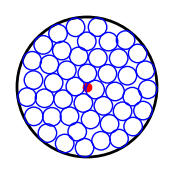

 22%|██▏       | 2201/10000 [1:53:59<16:53:58,  7.80s/it]

##########################


 23%|██▎       | 2300/10000 [2:06:08<15:53:34,  7.43s/it]

Epcoh 2300
Packing Density : 0.776


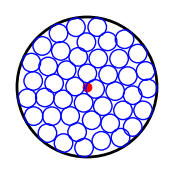

 23%|██▎       | 2301/10000 [2:06:17<16:45:31,  7.84s/it]

##########################


 24%|██▍       | 2400/10000 [2:18:09<15:12:53,  7.21s/it]

Epcoh 2400
Packing Density : 0.77693


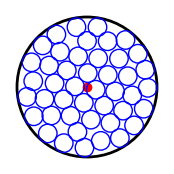

 24%|██▍       | 2401/10000 [2:18:17<15:40:49,  7.43s/it]

##########################


 25%|██▌       | 2500/10000 [2:29:28<6:51:25,  3.29s/it] 

Epcoh 2500
Packing Density : 0.77921


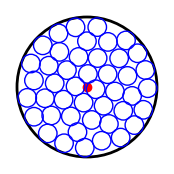

 25%|██▌       | 2501/10000 [2:29:32<6:53:28,  3.31s/it]

##########################


 26%|██▌       | 2600/10000 [2:34:40<6:29:24,  3.16s/it]

Epcoh 2600
Packing Density : 0.77706


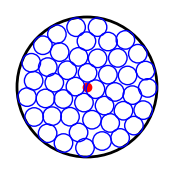

 26%|██▌       | 2601/10000 [2:34:43<6:27:45,  3.14s/it]

##########################


 27%|██▋       | 2700/10000 [2:39:36<6:20:19,  3.13s/it]

Epcoh 2700
Packing Density : 0.77759


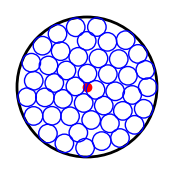

 27%|██▋       | 2701/10000 [2:39:39<6:39:02,  3.28s/it]

##########################


 28%|██▊       | 2800/10000 [2:44:26<5:38:00,  2.82s/it]

Epcoh 2800
Packing Density : 0.77915


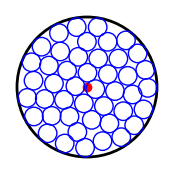

 28%|██▊       | 2801/10000 [2:44:29<5:50:28,  2.92s/it]

##########################


 29%|██▉       | 2900/10000 [2:49:06<5:26:58,  2.76s/it]

Epcoh 2900
Packing Density : 0.77912


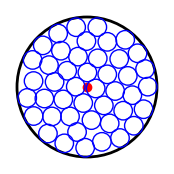

 29%|██▉       | 2901/10000 [2:49:09<5:35:39,  2.84s/it]

##########################


 30%|███       | 3000/10000 [2:53:53<5:39:04,  2.91s/it]

Epcoh 3000
Packing Density : 0.78032


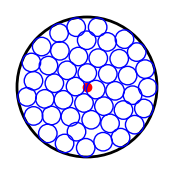

 30%|███       | 3001/10000 [2:53:56<5:46:09,  2.97s/it]

##########################


 31%|███       | 3100/10000 [2:58:35<5:20:54,  2.79s/it]

Epcoh 3100
Packing Density : 0.77886


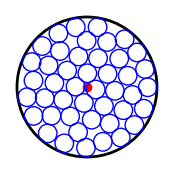

 31%|███       | 3101/10000 [2:58:38<5:32:43,  2.89s/it]

##########################


 32%|███▏      | 3200/10000 [3:03:30<5:53:44,  3.12s/it]

Epcoh 3200
Packing Density : 0.78018


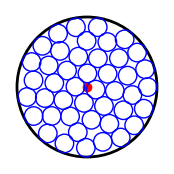

 32%|███▏      | 3201/10000 [3:03:33<6:00:47,  3.18s/it]

##########################


 33%|███▎      | 3300/10000 [3:08:27<5:47:34,  3.11s/it]

Epcoh 3300
Packing Density : 0.78005


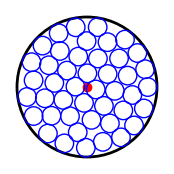

 33%|███▎      | 3301/10000 [3:08:31<6:38:22,  3.57s/it]

##########################


 34%|███▍      | 3400/10000 [3:13:21<5:01:40,  2.74s/it] 

Epcoh 3400
Packing Density : 0.78034


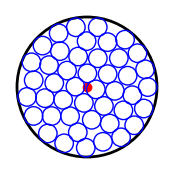

 34%|███▍      | 3401/10000 [3:13:24<5:15:14,  2.87s/it]

##########################


 35%|███▌      | 3500/10000 [3:17:56<5:00:44,  2.78s/it]

Epcoh 3500
Packing Density : 0.7793


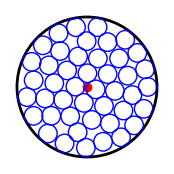

 35%|███▌      | 3501/10000 [3:17:59<5:10:24,  2.87s/it]

##########################


 36%|███▌      | 3600/10000 [3:22:30<5:01:18,  2.82s/it]

Epcoh 3600
Packing Density : 0.77872


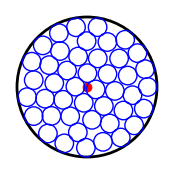

 36%|███▌      | 3601/10000 [3:22:34<5:12:01,  2.93s/it]

##########################


 37%|███▋      | 3700/10000 [3:27:04<4:47:17,  2.74s/it]

Epcoh 3700
Packing Density : 0.7799


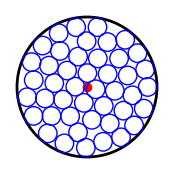

 37%|███▋      | 3701/10000 [3:27:07<4:52:53,  2.79s/it]

##########################


 38%|███▊      | 3800/10000 [3:31:39<4:42:44,  2.74s/it]

Epcoh 3800
Packing Density : 0.78127


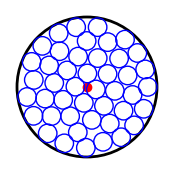

 38%|███▊      | 3801/10000 [3:31:42<4:52:21,  2.83s/it]

##########################


 39%|███▉      | 3900/10000 [3:36:13<4:39:07,  2.75s/it]

Epcoh 3900
Packing Density : 0.77942


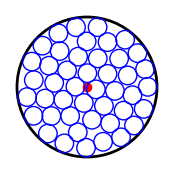

 39%|███▉      | 3901/10000 [3:36:16<4:46:22,  2.82s/it]

##########################


 40%|████      | 4000/10000 [3:40:49<4:32:54,  2.73s/it]

Epcoh 4000
Packing Density : 0.77931


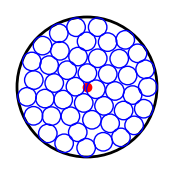

 40%|████      | 4001/10000 [3:40:52<4:40:56,  2.81s/it]

##########################


 41%|████      | 4100/10000 [3:45:23<4:28:56,  2.73s/it]

Epcoh 4100
Packing Density : 0.7797


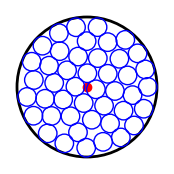

 41%|████      | 4101/10000 [3:45:27<4:37:31,  2.82s/it]

##########################


 42%|████▏     | 4200/10000 [3:50:00<4:33:41,  2.83s/it]

Epcoh 4200
Packing Density : 0.78196


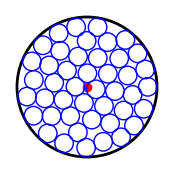

 42%|████▏     | 4201/10000 [3:50:03<4:37:14,  2.87s/it]

##########################


 43%|████▎     | 4300/10000 [3:54:36<4:24:22,  2.78s/it]

Epcoh 4300
Packing Density : 0.77928


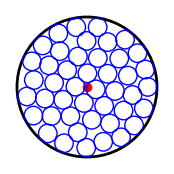

 43%|████▎     | 4301/10000 [3:54:39<4:33:54,  2.88s/it]

##########################


 44%|████▍     | 4400/10000 [3:59:10<4:17:17,  2.76s/it]

Epcoh 4400
Packing Density : 0.78026


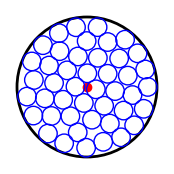

 44%|████▍     | 4401/10000 [3:59:13<4:24:39,  2.84s/it]

##########################


 45%|████▌     | 4500/10000 [4:03:47<4:10:51,  2.74s/it]

Epcoh 4500
Packing Density : 0.78002


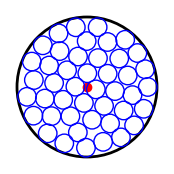

 45%|████▌     | 4501/10000 [4:03:50<4:22:16,  2.86s/it]

##########################


 46%|████▌     | 4600/10000 [4:08:21<4:05:07,  2.72s/it]

Epcoh 4600
Packing Density : 0.77988


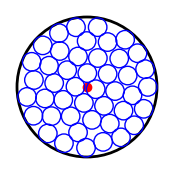

 46%|████▌     | 4601/10000 [4:08:24<4:14:01,  2.82s/it]

##########################


 47%|████▋     | 4700/10000 [4:12:58<4:04:11,  2.76s/it]

Epcoh 4700
Packing Density : 0.78074


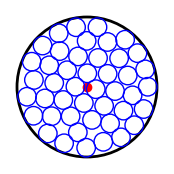

 47%|████▋     | 4701/10000 [4:13:01<4:09:56,  2.83s/it]

##########################


 48%|████▊     | 4800/10000 [4:17:34<3:58:41,  2.75s/it]

Epcoh 4800
Packing Density : 0.77961


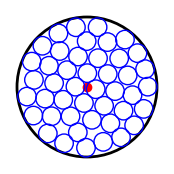

 48%|████▊     | 4801/10000 [4:17:37<4:04:00,  2.82s/it]

##########################


 49%|████▉     | 4900/10000 [4:22:08<3:52:22,  2.73s/it]

Epcoh 4900
Packing Density : 0.77626


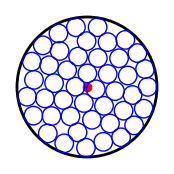

 49%|████▉     | 4901/10000 [4:22:11<3:58:41,  2.81s/it]

##########################


 50%|█████     | 5000/10000 [4:26:43<3:49:19,  2.75s/it]

Epcoh 5000
Packing Density : 0.77938


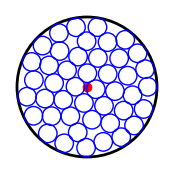

 50%|█████     | 5001/10000 [4:26:46<3:56:43,  2.84s/it]

##########################


 51%|█████     | 5100/10000 [4:31:19<3:41:23,  2.71s/it]

Epcoh 5100
Packing Density : 0.77984


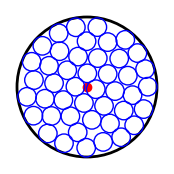

 51%|█████     | 5101/10000 [4:31:22<3:50:48,  2.83s/it]

##########################


 52%|█████▏    | 5200/10000 [4:35:55<3:39:25,  2.74s/it]

Epcoh 5200
Packing Density : 0.7822


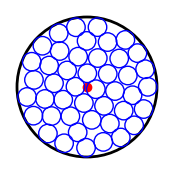

 52%|█████▏    | 5201/10000 [4:35:58<3:59:41,  3.00s/it]

##########################


 53%|█████▎    | 5300/10000 [4:40:30<3:34:12,  2.73s/it]

Epcoh 5300
Packing Density : 0.77792


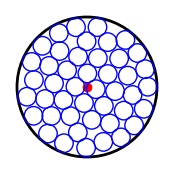

 53%|█████▎    | 5301/10000 [4:40:33<3:42:35,  2.84s/it]

##########################


 54%|█████▍    | 5400/10000 [4:45:07<3:38:54,  2.86s/it]

Epcoh 5400
Packing Density : 0.78014


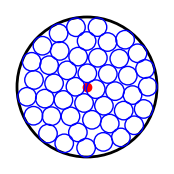

 54%|█████▍    | 5401/10000 [4:45:10<3:42:48,  2.91s/it]

##########################


 54%|█████▍    | 5421/10000 [4:46:15<4:01:47,  3.17s/it]


KeyboardInterrupt: 

In [31]:
# Parameters
num_circles = 45 #127
large_radius = 1.0
small_radius = 0.132049594251630179295715088299
#small_radius = 	#0.080246842401966631917112929101
BATCHES = 200
EPOCHS = 10000
DEVICE = "cuda"

# Initialize input data and loss function
eye = one_hot(np.arange(0, num_circles), num_circles)
Input = eye.repeat(BATCHES, 1, 1).to(DEVICE)

#model = EncoderDecoder(num_circles, large_radius, small_radius).to(DEVICE)
model = torch.load('model.pth').to(DEVICE)

loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
optim2 = torch.optim.Adam(model.parameters(), lr=0.00005)
optim3 = torch.optim.Adam(model.parameters(), lr=0.000005)
alpha = 16
beta = 2
loss_list = []
# Training loop
for epoch in tqdm(range(EPOCHS)):
    # if epoch == 100 :
    #     alpha = 2
    #     beta = 4
    # # if epoch == 500 :
    # #     alpha = 4
    # #     beta = 8
    # if epoch == 300 :
    #     alpha = 2
    #     beta = 2
    # if epoch == 3500 :
    #     alpha = 8
    #     beta = 2
    # if epoch == 4500 :
    #     alpha = 16
    #     beta = 2
    epoch_loss = 0
    if epoch < 3000:
        for inputs in Input:
            # indices = torch.randperm(inputs.shape[0])[:10]
            # inputs = inputs[indices]
            optim.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))#torch.cat((inputs.argmax(dim=1), inputs.argmax(dim=1), inputs.argmax(dim=1)), dim=0))
            curr_loss.backward()
            optim.step()
            epoch_loss += curr_loss.detach().cpu()
    if epoch >= 3000 and epoch < 7000:
        for inputs in Input: 
            optim2.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim2.step()
            epoch_loss += curr_loss.detach().cpu()
    if epoch >= 7000:
        for inputs in Input: 
            optim3.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim3.step()
            epoch_loss += curr_loss.detach().cpu()
    loss_list.append(epoch_loss)
    if epoch % 100 == 0:
        print(f"Epcoh {epoch}") 
        centres = model.centres(eye)
        print(f"Packing Density : {packing_density(centres, small_radius, large_radius)}")
        # print(f"Circle Config : ")
        plot_circles(centres, large_radius, small_radius)
        print("##########################")

centres = model.centres(eye)
plot_circles(centres, large_radius, small_radius)

In [32]:
torch.save(model, 'model.pth')

In [33]:
from matplotlib.colors import ListedColormap, to_rgba_array

# Example list of 25 hex color values
hex_colors = [
    '#dcdcdc', '#8b4513', '#708090', '#808000', '#483d8b',
    '#3cb371', '#000080', '#9acd32', '#8b008b', '#48d1cc',
    '#ff4500', '#ffa500', '#ffff00', '#00ff00', '#8a2be2',
    '#00ff7f', '#00bfff', '#0000ff', '#ff00ff', '#1e90ff',
    '#db7093', '#f0e68c', '#ff1493', '#ffa07a', '#ee82ee',
    '#dff993', '#66e68c', '#edc033', '#afbf55', '#ad4512',
    '#b99b95', '#ababab', '#12a800', '#4a1150', '#ffddbb',
    '#b316ff', '#aff551', '#fd5522', '#a22f4d', '#afa552',
    '#ffffff', '#c256aa', '#cc4df5', '#ddd555', '#15a2d3',
]

# Convert hex colors to RGBA format
rgba_colors = [to_rgba_array(color) for color in hex_colors]

# Create ListedColormap
custom_cmap = ListedColormap(rgba_colors, name='custom_cmap')

THIS IS WHAT ENCODER LEARNS TO DO
This is regions in decoder


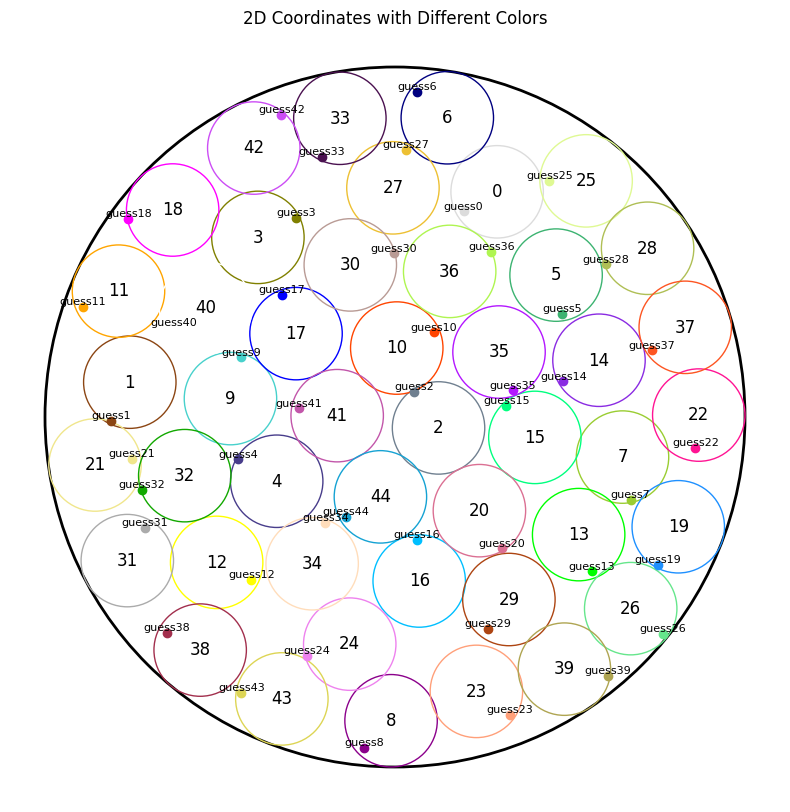

0

In [34]:
print("THIS IS WHAT ENCODER LEARNS TO DO") 
centres = model.centres(eye)
colors = custom_cmap
plot_circles_2(centres, large_radius, small_radius, colors, save=False)
print("This is regions in decoder")
model.regions(eye, alpha, beta, colors)

THIS IS WHAT ENCODER LEARNS TO DO
Packing Density : 0.72881
Centers :


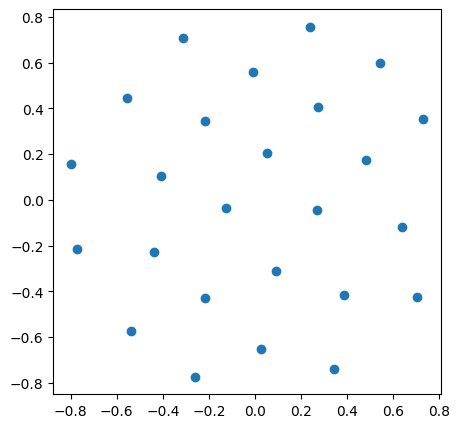

Circle Config : 


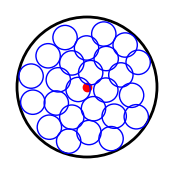

##########################


In [35]:
print("THIS IS WHAT ENCODER LEARNS TO DO") 
centres = model.centres(eye)
print(f"Packing Density : {packing_density(centres, small_radius, large_radius)}")
print(f"Centers :")
plt.figure(figsize=(5,5))
plt.scatter(centres[:,0], centres[:,1])
plt.show()
print(f"Circle Config : ")
plot_circles(centres, large_radius, small_radius)
print("##########################")

In [ ]:
# ########### MODEL CLASSES ###############


# class NormalizationLayer(nn.Module):
#     def __init__(self, maxnorm, input_shape):
#         super(NormalizationLayer, self).__init__()
#         self.maxnorm = maxnorm
#         self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
#         self.sigmoid = nn.Sigmoid()
#         self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
#     def forward(self, inputs):
#         output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
#         return output
    
# class NoiseLayer(nn.Module):
#     def __init__(self, noise_radius):
#         super(NoiseLayer, self).__init__()
#         self.noise_radius = noise_radius
#         self.alpha = 0.5
        
#     def spherical_gaussian(self, num_circles):
#         x = torch.randn(num_circles, 2)
#         u = torch.rand(num_circles, 1)
#         norm = torch.norm(x, dim=1, keepdim=True, p=2)
#         noise = x * (u.pow(self.alpha)) * self.noise_radius / norm
#         return noise

#     def forward(self, inputs, alpha):
#         self.alpha = alpha
#         noise = self.spherical_gaussian(inputs.size(0))
#         return inputs + noise
    

# class EncoderDecoder(nn.Module):
#     def __init__(self, num_circles, larger_radius, smaller_radius):
#         super(EncoderDecoder, self).__init__()
        
#         self.main_dim = num_circles
#         self.latent_dim = 2
#         self.R = larger_radius
#         self.r = smaller_radius
#         self.mid_dim = 30
#         self.alpha = 0.5

#         self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
#         self.noise = NoiseLayer(self.r)
        
#         self.encoder = nn.Sequential(
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.SELU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.SELU(),
#             nn.Linear(self.main_dim, self.latent_dim),
#             nn.Tanh()
#         )       
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.main_dim),
#             nn.ReLU(),
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.ReLU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.Softmax(dim=1)
#         )
        
#     def forward(self, x, alpha):
#         self.alpha = alpha
#         encoded = self.encoder(x)
#         normed_encoded = self.normalize(encoded)
#         noisy_encoded = self.noise(normed_encoded, alpha)
#         decoded = self.decoder(noisy_encoded)
#         return decoded

#     def centres(self, x):
#         return self.normalize(self.encoder(x)).detach().numpy()